In [54]:
import numpy as np 
import pandas as pd 
import os  
import json 
from xgboost import XGBClassifier  
import pandas_ta as ta 
from tqdm import tqdm 
import ccxt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight 
from sklearn.metrics import f1_score

In [39]:
files = os.listdir("./upbit")
len(files), files[:5]

(115,
 ['IQ_KRW-1h.json',
  'T_KRW-1h.json',
  'SHIB_KRW-1h.json',
  'ONG_KRW-1h.json',
  'THETA_KRW-1h.json'])

In [72]:
chart_dfs = [] 

def process(df): 
    upbit = ccxt.upbit()  
    dates = df["timestamp"].values 
    timestamp = [] 
    for i in range(len(dates)):
        date_string = upbit.iso8601(int(dates[i])) 
        date_string = date_string[:10] + " " + date_string[11:-5] 
        timestamp.append(date_string) 
    df["datetime"] = timestamp
    df = df.drop(columns={"timestamp"}) 
    return df 

for i in tqdm(range(len(files))): 
    try: 
        with open("./upbit/" + str(files[i])) as f: 
            d = json.load(f) 
        chart_df = pd.DataFrame(d) 
        chart_df = chart_df.rename(columns={0:"timestamp", 1:"open", 2:"high", 3:"low", 4:"close", 5:"volume"}) 
        chart_df = process(chart_df)  
        chart_dfs.append(chart_df) 
    except: 
        continue

100%|██████████| 115/115 [00:09<00:00, 12.23it/s]


In [73]:
len(chart_dfs) # an error with one of the files I guess 

114

In [74]:
# process each chart df separately, then merge them all together
# then when running real time, we can monitor the entire market to find the ones with buy signals 
# we can then either invest in the top 1 or top K 
def feature_engineering(chart_df, threshold=0.01): 
    hours, days, months, years = [],[],[],[] 
    for dt in chart_df["datetime"]:
            dtobj = pd.to_datetime(dt) 
            hour = dtobj.hour 
            day = dtobj.day 
            month = dtobj.month 
            year = dtobj.year 
            hours.append(hour) 
            days.append(day) 
            months.append(month) 
            years.append(year) 

    chart_df["hours"] = hours 
    chart_df["days"] = days  
    chart_df["months"] = months 
    chart_df["years"] = years 
    
    targets = [] 
    openv = chart_df["open"].values 
    close = chart_df["close"].values 
    high = chart_df["high"].values 
    low = chart_df["low"].values  
    volume = chart_df["volume"].values 
    
    for i in range(close.shape[0]-1):
        high_vol = (high[i+1] - close[i]) / close[i] 
        if high_vol >= threshold: 
            targets.append(1) 
        else:
            targets.append(0) 
    targets.append(None) 
    chart_df["Targets"] = targets 
    
    chart_df.set_index(pd.DatetimeIndex(chart_df["datetime"]), inplace=True)
    chart_df["bop"] = chart_df.ta.bop(lookahead=False) 
    chart_df["ebsw"] = chart_df.ta.ebsw(lookahead=False) 
    chart_df["cmf"] = chart_df.ta.cmf(lookahead=False) 
    chart_df["high/low"] = chart_df["high"] / chart_df["low"] 
    chart_df["high/open"] = chart_df["high"] / chart_df["open"] 
    chart_df["low/open"] = chart_df["low"] / chart_df["open"] 
    chart_df["close/open"] = chart_df["close"] / chart_df["open"] 
    chart_df["high/close"] = chart_df["high"] / chart_df["close"] 
    chart_df["low/close"] = chart_df["low"] / chart_df["close"]     
    for l in range(1, 12): 
        for col in ["open", "high", "low", "close", "volume"]:
            val = chart_df[col].values 
            val_ret = [None for _ in range(l)]
            for i in range(l, len(val)):
                if val[i-l] == 0: 
                    ret = 1 
                else:
                    ret = val[i] / val[i-l]  
                val_ret.append(ret) 
            chart_df["{}_change_{}".format(col, l)] = val_ret 
    chart_df.dropna(inplace=True) 
    chart_df.drop(columns={"open", "high", "low", "close", "volume"}, inplace=True) 
    return chart_df



In [75]:
processed_chart_dfs = [] 

for i in tqdm(range(len(chart_dfs)), position=0, leave=True): 
    chart_df = feature_engineering(chart_dfs[i]) 
    processed_chart_dfs.append(chart_df)
    break 

  0%|          | 0/114 [00:01<?, ?it/s]


In [44]:
processed_chart_dfs = pd.concat(processed_chart_dfs)  
processed_chart_dfs.shape

(1421058, 70)

In [45]:
processed_chart_dfs = processed_chart_dfs.drop(columns={"datetime", "years"})  

processed_chart_dfs.head(3)  

,hours,days,months,Targets,bop,ebsw,cmf,high/low,high/open,low/open,...,open_change_10,high_change_10,low_change_10,close_change_10,volume_change_10,open_change_11,high_change_11,low_change_11,close_change_11,volume_change_11
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-04 00:00:00,0,4,8,0.0,-0.200000,0.000000,-0.267754,1.057252,1.000000,0.945848,...,0.955172,0.948630,0.912892,0.954704,1.096430,0.968531,0.955172,0.922535,0.944828,1.486918
2018-08-04 01:00:00,1,4,8,0.0,-0.125000,0.577350,-0.216649,1.029963,1.003650,0.974453,...,0.954704,0.938567,0.936842,0.951220,0.939002,0.944828,0.941781,0.930314,0.951220,1.258872
2018-08-04 02:00:00,2,4,8,1.0,-0.666667,0.800392,-0.241816,1.108871,1.007326,0.908425,...,0.951220,0.954861,0.873239,0.891608,10.549937,0.951220,0.938567,0.870175,0.888502,4.106668


In [82]:
chart_df = chart_df.drop(columns={"datetime", "years"}) 
chart_df.head()

,hours,days,months,Targets,bop,ebsw,cmf,high/low,high/open,low/open,...,open_change_10,high_change_10,low_change_10,close_change_10,volume_change_10,open_change_11,high_change_11,low_change_11,close_change_11,volume_change_11
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-04 00:00:00,0,4,8,0.0,-2.000000e-01,0.000000,-0.267754,1.057252,1.000000,0.945848,...,0.955172,0.948630,0.912892,0.954704,1.096430,0.968531,0.955172,0.922535,0.944828,1.486918
2018-08-04 01:00:00,1,4,8,0.0,-1.250000e-01,0.577350,-0.216649,1.029963,1.003650,0.974453,...,0.954704,0.938567,0.936842,0.951220,0.939002,0.944828,0.941781,0.930314,0.951220,1.258872
2018-08-04 02:00:00,2,4,8,1.0,-6.666667e-01,0.800392,-0.241816,1.108871,1.007326,0.908425,...,0.951220,0.954861,0.873239,0.891608,10.549937,0.951220,0.938567,0.870175,0.888502,4.106668
2018-08-04 03:00:00,3,4,8,1.0,2.467162e-16,0.985586,-0.259558,1.035857,1.019608,0.984314,...,0.891608,0.905923,0.883803,0.891608,6.261808,0.888502,0.902778,0.883803,0.891608,2.365352
2018-08-04 04:00:00,4,4,8,0.0,2.000000e-01,0.983857,-0.105410,1.019763,1.007812,0.988281,...,0.895105,0.898955,0.900356,0.914591,1.533696,0.895105,0.898955,0.890845,0.898601,4.176237


<AxesSubplot:xlabel='Targets', ylabel='count'>

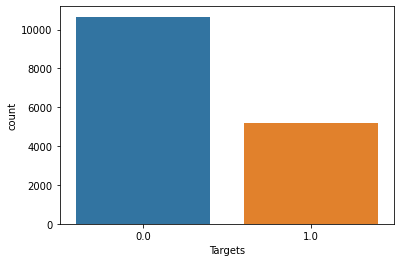

In [83]:
sns.countplot(chart_df, x="Targets") 

In [84]:
train_columns = [] 
for col in chart_df.columns: 
    train_columns.append(col) 
    
X = chart_df[train_columns] 
Y = chart_df["Targets"] 

train_size = int(0.8 * X.shape[0]) 
val_size = int(0.1 * X.shape[0]) 

X_train = X.iloc[:train_size] 
Y_train = Y.iloc[:train_size]

X_val = X.iloc[train_size:train_size+val_size] 
Y_val = Y.iloc[train_size:train_size+val_size]  

X_test = X.iloc[train_size+val_size:] 
Y_test = Y.iloc[train_size+val_size:] 

X_train.shape, X_val.shape, X_test.shape 

((12673, 68), (1584, 68), (1585, 68))

In [85]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(Y_train), y=Y_train.values) 
class_weights

array([0.77133293, 1.4213773 ])

In [86]:
clf = XGBClassifier(silent=False, 
                    n_estimators=1000,
                    class_weight=class_weights, 
                    metric="logloss",
                    tree_method="gpu_hist")

clf.fit(X_train, 
        Y_train, 
        eval_set=[(X_val, Y_val)],
        verbose=20)


[05:44:21] WARNING: ../src/learner.cc:576: 
Parameters: { "class_weight", "metric", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:44:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.43761


/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-logloss:0.00094
[40]	validation_0-logloss:0.00014
[60]	validation_0-logloss:0.00014
[80]	validation_0-logloss:0.00014
[100]	validation_0-logloss:0.00014
[120]	validation_0-logloss:0.00014
[140]	validation_0-logloss:0.00014
[160]	validation_0-logloss:0.00014
[180]	validation_0-logloss:0.00014
[200]	validation_0-logloss:0.00014
[220]	validation_0-logloss:0.00014
[240]	validation_0-logloss:0.00014
[260]	validation_0-logloss:0.00014
[280]	validation_0-logloss:0.00014
[300]	validation_0-logloss:0.00014
[320]	validation_0-logloss:0.00014
[340]	validation_0-logloss:0.00014
[360]	validation_0-logloss:0.00014
[380]	validation_0-logloss:0.00014
[400]	validation_0-logloss:0.00014
[420]	validation_0-logloss:0.00014
[440]	validation_0-logloss:0.00014
[460]	validation_0-logloss:0.00014
[480]	validation_0-logloss:0.00014
[500]	validation_0-logloss:0.00014
[520]	validation_0-logloss:0.00014
[540]	validation_0-logloss:0.00014
[560]	validation_0-logloss:0.00014
[580]	validation_0-loglo

XGBClassifier(base_score=0.5, booster='gbtree',
              class_weight=array([0.77133293, 1.4213773 ]), colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, metric='logloss',
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, silent=False, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, ...)

In [87]:
Y_pred = clf.predict(X_test) 

cnt = 0 

for i in range(len(Y_pred)): 
    if Y_pred[i] == Y_test[i]: 
        cnt += 1 
        
accuracy = cnt / len(Y_pred) * 100.0 
f1 = f1_score(Y_test, Y_pred, average="macro") 


print(f"accuracy: {accuracy}% | Macro F1: {f1}")

accuracy: 100.0% | Macro F1: 1.0
